In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")


✅ Libraries imported!


In [2]:
# =============================================================================
# CELL 2: Load WA Dataset
# =============================================================================
print("📁 Loading WA Telecom Dataset...")
wa_data = pd.read_csv('/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"✅ Loaded: {wa_data.shape}")
print(f"Columns: {list(wa_data.columns)}")
print("\nFirst 3 rows:")
display(wa_data.head(15))


📁 Loading WA Telecom Dataset...
✅ Loaded: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 3 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
# =============================================================================
# CELL 3: Enhanced Data Cleaning & Preprocessing
# =============================================================================
# Strip whitespace from string columns
wa_data = wa_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Convert 'TotalCharges' to numeric (some may be empty strings)
wa_data['TotalCharges'] = pd.to_numeric(wa_data['TotalCharges'], errors='coerce')

# Fill missing numeric values
num_cols = wa_data.select_dtypes(include=['float64','int64']).columns
wa_data[num_cols] = wa_data[num_cols].fillna(wa_data[num_cols].median())

# =============================================================================
# DROP NON-PREDICTIVE IDENTIFIERS
# =============================================================================
# Remove customerID - unique identifier with no predictive power
if 'customerID' in wa_data.columns:
    wa_data = wa_data.drop('customerID', axis=1)
    print("✅ Dropped 'customerID' column")

# =============================================================================
# HANDLE ANY NaN VALUES IN CATEGORICAL COLUMNS BEFORE ENCODING
# =============================================================================
# Fill NaN in categorical columns with 'Unknown' before encoding
cat_cols_with_nan = wa_data.select_dtypes(include=['object']).columns
for col in cat_cols_with_nan:
    if wa_data[col].isnull().any():
        print(f"⚠️  Found {wa_data[col].isnull().sum()} NaN values in '{col}' - filling with 'Unknown'")
        wa_data[col] = wa_data[col].fillna('Unknown')

# =============================================================================
# SPECIAL HANDLING: "No internet service" and "No phone service"
# =============================================================================
# These represent a different category than just "No", so encode separately

# Columns that have "No internet service" as a value
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                           'TechSupport', 'StreamingTV', 'StreamingMovies']

# Encode: Yes=1, No=0, No internet service=2
for col in internet_dependent_cols:
    if col in wa_data.columns:
        wa_data[col] = wa_data[col].map({
            'Yes': 1,
            'No': 0,
            'No internet service': 2
        })
        # Fill any unmapped values (NaN from mapping) with 0
        wa_data[col] = wa_data[col].fillna(0)

# MultipleLines: Yes=1, No=0, No phone service=2
if 'MultipleLines' in wa_data.columns:
    wa_data['MultipleLines'] = wa_data['MultipleLines'].map({  # FIXED: was using 'col'
        'Yes': 1,
        'No': 0,
        'No phone service': 2
    })
    # Fill any unmapped values with 0
    wa_data['MultipleLines'] = wa_data['MultipleLines'].fillna(0)

# =============================================================================
# ENCODE OTHER BINARY VARIABLES
# =============================================================================
# These are true binary (only Yes/No or Female/Male)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
               'PaperlessBilling', 'Churn']

for col in binary_cols:
    if col in wa_data.columns:
        # Check for any NaN before encoding
        if wa_data[col].isnull().any():
            print(f"⚠️  Found NaN in '{col}' before encoding - this shouldn't happen!")
            wa_data[col] = wa_data[col].fillna(wa_data[col].mode()[0])  # Fill with most common

        le = LabelEncoder()
        wa_data[col] = le.fit_transform(wa_data[col])

# =============================================================================
# ONE-HOT ENCODE REMAINING CATEGORICAL VARIABLES
# =============================================================================
# This includes: InternetService, Contract, PaymentMethod
cat_cols = wa_data.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    wa_data = pd.get_dummies(wa_data, columns=cat_cols, drop_first=True)

print("✅ Enhanced preprocessing complete")
print(f"Final feature count: {wa_data.shape[1]}")

# Final check for any remaining NaN values
if wa_data.isnull().any().any():
    print("\n⚠️  WARNING: NaN values still present after preprocessing!")
    print("Columns with NaN:")
    print(wa_data.columns[wa_data.isnull().any()].tolist())
else:
    print("✅ No NaN values detected - data is clean!")

✅ Dropped 'customerID' column
✅ Enhanced preprocessing complete
Final feature count: 24
✅ No NaN values detected - data is clean!


CHURN ANALYSIS - TARGET DISTRIBUTION
Total Customers: 7043
Churned: 1869 (26.54%)
Retained: 5174 (73.46%)
Class Imbalance Ratio: 2.77:1

FEATURE CORRELATION WITH CHURN

📈 TOP 10 POSITIVE CORRELATES (Higher value → Higher churn risk)
--------------------------------------------------------------------------------
 1. InternetService_Fiber optic              r=+0.3080 ***
 2. PaymentMethod_Electronic check           r=+0.3019 ***
 3. MonthlyCharges                           r=+0.1934 ***
 4. PaperlessBilling                         r=+0.1918 ***
 5. SeniorCitizen                            r=+0.1509 ***
 6. MultipleLines                            r=+0.0194 
 7. PhoneService                             r=+0.0119 

📉 TOP 10 NEGATIVE CORRELATES (Higher value → Lower churn risk)
--------------------------------------------------------------------------------
 1. tenure                                   r=-0.3522 ***
 2. OnlineSecurity                           r=-0.3328 ***
 3. TechSupport 

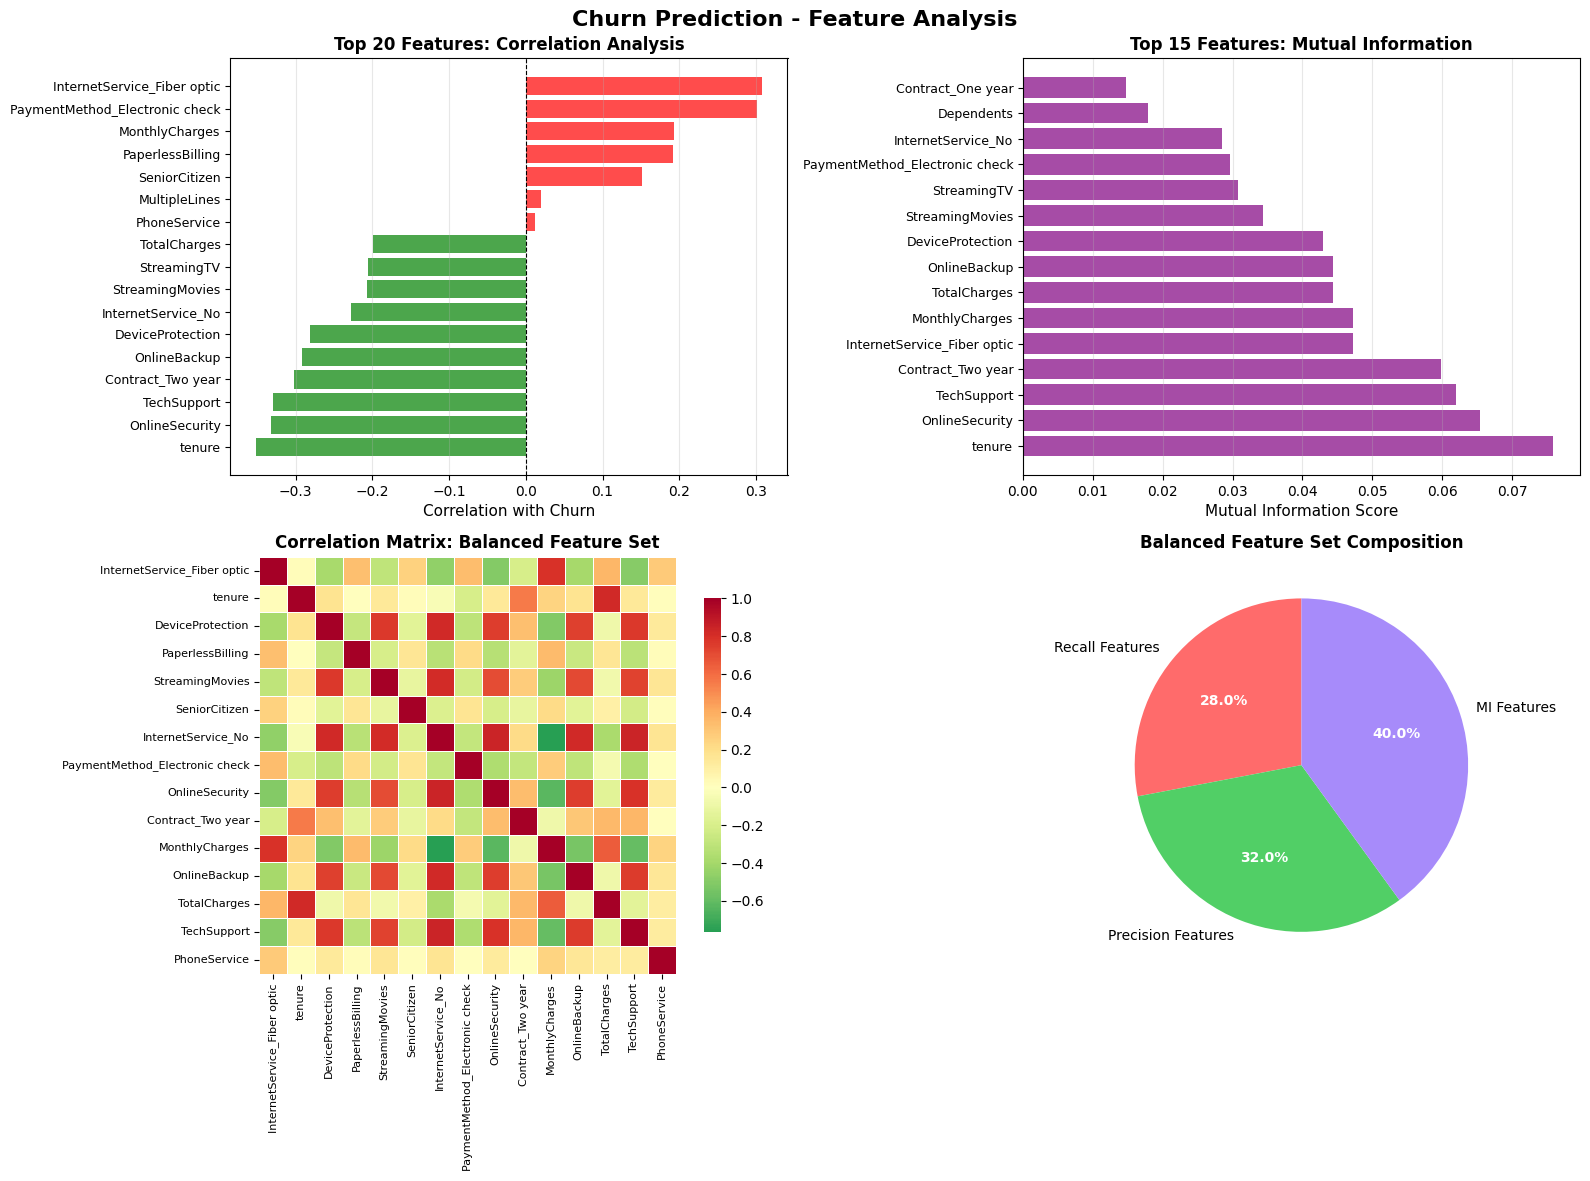


FINAL RECOMMENDATIONS

🎯 BALANCED FEATURE SET FOR CHURN PREDICTION:
--------------------------------------------------------------------------------
 1. Contract_Two year                        | Corr=-0.302 | MI=0.0599
 2. DeviceProtection                         | Corr=-0.281 | MI=0.0429
 3. InternetService_Fiber optic              | Corr=+0.308 | MI=0.0473
 4. InternetService_No                       | Corr=-0.228 | MI=0.0286
 5. MonthlyCharges                           | Corr=+0.193 | MI=0.0473
 6. MultipleLines                            | Corr=+0.019 | MI=0.0000
 7. OnlineBackup                             | Corr=-0.291 | MI=0.0443
 8. OnlineSecurity                           | Corr=-0.333 | MI=0.0654
 9. PaperlessBilling                         | Corr=+0.192 | MI=0.0145
10. PaymentMethod_Electronic check           | Corr=+0.302 | MI=0.0296
11. PhoneService                             | Corr=+0.012 | MI=0.0029
12. SeniorCitizen                            | Corr=+0.151 | MI=0.006

In [5]:
# =============================================================================
# CELL 4: Target Definition & Comprehensive Statistical Analysis
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# STEP 1: Define Target Variable
# =============================================================================
y = wa_data['Churn']
X = wa_data.drop('Churn', axis=1)

print("="*80)
print("CHURN ANALYSIS - TARGET DISTRIBUTION")
print("="*80)
print(f"Total Customers: {len(y)}")
print(f"Churned: {y.sum()} ({y.mean()*100:.2f}%)")
print(f"Retained: {len(y) - y.sum()} ({(1-y.mean())*100:.2f}%)")
print(f"Class Imbalance Ratio: {(1-y.mean())/y.mean():.2f}:1")
print()

# =============================================================================
# STEP 2: Correlation Analysis - Identify Positive & Negative Correlates
# =============================================================================
print("="*80)
print("FEATURE CORRELATION WITH CHURN")
print("="*80)

# Calculate correlations for all numeric features
correlations = {}
for col in X.columns:
    # Point-biserial correlation (for binary target with numeric features)
    corr, p_value = pointbiserialr(y, X[col])
    correlations[col] = {'correlation': corr, 'p_value': p_value}

# Create DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.sort_values('correlation', key=abs, ascending=False)

# Identify positive and negative correlates
positive_correlates = corr_df[corr_df['correlation'] > 0].sort_values('correlation', ascending=False)
negative_correlates = corr_df[corr_df['correlation'] < 0].sort_values('correlation', ascending=True)

print("\n📈 TOP 10 POSITIVE CORRELATES (Higher value → Higher churn risk)")
print("-" * 80)
for idx, (feature, row) in enumerate(positive_correlates.head(10).iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{idx:2d}. {feature:40s} r={row['correlation']:+.4f} {sig}")

print("\n📉 TOP 10 NEGATIVE CORRELATES (Higher value → Lower churn risk)")
print("-" * 80)
for idx, (feature, row) in enumerate(negative_correlates.head(10).iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{idx:2d}. {feature:40s} r={row['correlation']:+.4f} {sig}")

# =============================================================================
# STEP 3: Mutual Information - Capture Non-Linear Relationships
# =============================================================================
print("\n" + "="*80)
print("MUTUAL INFORMATION ANALYSIS (Non-linear feature importance)")
print("="*80)

# Check for and handle any remaining NaN values
if X.isnull().any().any():
    print("⚠️  Warning: Found NaN values in features.")
    nan_cols = X.columns[X.isnull().any()].tolist()
    print(f"   Columns with NaN: {nan_cols}")

    # Fill numeric columns with median, others with 0
    for col in X.columns:
        if X[col].isnull().any():
            if X[col].dtype in ['float64', 'int64']:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(0)

    print("✅ NaN values handled")

# Double check - if still NaN, fill everything with 0
if X.isnull().any().any():
    print("⚠️  Stubborn NaNs detected. Filling all remaining with 0...")
    X = X.fillna(0)

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\n🔍 TOP 15 FEATURES BY MUTUAL INFORMATION")
print("-" * 80)
for idx, row in mi_df.head(15).iterrows():
    print(f"{idx+1:2d}. {row['feature']:40s} MI={row['mi_score']:.4f}")

# =============================================================================
# STEP 4: Feature Engineering - Create Balanced Feature Set
# =============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING FOR BALANCED PREDICTION")
print("="*80)

# Identify features for recall (high positive correlation - catch churners)
recall_features = positive_correlates.head(8).index.tolist()

# Identify features for precision (high negative correlation - avoid false positives)
precision_features = negative_correlates.head(8).index.tolist()

# Add high MI features that might be non-linear
mi_top_features = mi_df.head(10)['feature'].tolist()

# Combine into balanced feature set (remove duplicates)
balanced_features = list(set(recall_features + precision_features + mi_top_features))

print(f"\n✅ Engineered Balanced Feature Set: {len(balanced_features)} features")
print("\nFeature Categories:")
print(f"  • Recall-optimized (catch churners):     {len(recall_features)} features")
print(f"  • Precision-optimized (reduce false +):  {len(precision_features)} features")
print(f"  • Non-linear indicators (MI):             {len(mi_top_features)} features")

# =============================================================================
# STEP 5: Multicollinearity Check
# =============================================================================
print("\n" + "="*80)
print("MULTICOLLINEARITY ANALYSIS")
print("="*80)

X_balanced = X[balanced_features]
corr_matrix = X_balanced.corr().abs()

# Find highly correlated pairs (> 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs (r > 0.8):")
    for pair in high_corr_pairs:
        print(f"  • {pair['feature1']} ↔ {pair['feature2']}: r={pair['correlation']:.3f}")
    print("\n💡 Consider removing one feature from each pair to reduce multicollinearity")
else:
    print("\n✅ No severe multicollinearity detected (all pairwise r < 0.8)")

# =============================================================================
# STEP 6: Visualizations
# =============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Churn Prediction - Feature Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top Correlations (Positive & Negative)
ax1 = axes[0, 0]
top_features = pd.concat([
    positive_correlates.head(10),
    negative_correlates.head(10)
]).sort_values('correlation')
colors = ['red' if x > 0 else 'green' for x in top_features['correlation']]
ax1.barh(range(len(top_features)), top_features['correlation'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features.index, fontsize=9)
ax1.set_xlabel('Correlation with Churn', fontsize=11)
ax1.set_title('Top 20 Features: Correlation Analysis', fontsize=12, fontweight='bold')
ax1.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Mutual Information Scores
ax2 = axes[0, 1]
top_mi = mi_df.head(15)
ax2.barh(range(len(top_mi)), top_mi['mi_score'], color='purple', alpha=0.7)
ax2.set_yticks(range(len(top_mi)))
ax2.set_yticklabels(top_mi['feature'].values, fontsize=9)
ax2.set_xlabel('Mutual Information Score', fontsize=11)
ax2.set_title('Top 15 Features: Mutual Information', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Correlation Matrix of Balanced Features
ax3 = axes[1, 0]
top_balanced = balanced_features[:15]  # Show top 15 for readability
corr_subset = X[top_balanced].corr()
sns.heatmap(corr_subset, annot=False, cmap='RdYlGn_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax3)
ax3.set_title('Correlation Matrix: Balanced Feature Set', fontsize=12, fontweight='bold')
ax3.tick_params(axis='both', labelsize=8)

# Plot 4: Feature Type Distribution
ax4 = axes[1, 1]
feature_types = {
    'Recall Features': len([f for f in recall_features if f in balanced_features]),
    'Precision Features': len([f for f in precision_features if f in balanced_features]),
    'MI Features': len([f for f in mi_top_features if f in balanced_features])
}
colors_pie = ['#ff6b6b', '#51cf66', '#a78bfa']
wedges, texts, autotexts = ax4.pie(feature_types.values(), labels=feature_types.keys(),
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Balanced Feature Set Composition', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 7: Export Balanced Feature Set
# =============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("\n🎯 BALANCED FEATURE SET FOR CHURN PREDICTION:")
print("-" * 80)
for idx, feature in enumerate(sorted(balanced_features), 1):
    corr_val = corr_df.loc[feature, 'correlation']
    mi_val = mi_df[mi_df['feature'] == feature]['mi_score'].values[0]
    print(f"{idx:2d}. {feature:40s} | Corr={corr_val:+.3f} | MI={mi_val:.4f}")

print("\n💡 STRATEGY FOR RECALL-PRECISION BALANCE:")
print("-" * 80)
print("✓ Use recall-focused features (positive correlates) to catch potential churners")
print("✓ Use precision-focused features (negative correlates) to reduce false alarms")
print("✓ Include non-linear features (high MI) to capture complex patterns")
print("✓ Monitor class weights during model training to fine-tune balance")
print("\n✓ Next steps: Train with class_weight='balanced' or use SMOTE for sampling")

# Store for next cells
X_balanced_df = X[balanced_features]
print(f"\n✅ X_balanced_df created with {X_balanced_df.shape[1]} features")
print(f"✅ y (target) contains {len(y)} samples")

In [6]:
# =============================================================================
# CELL 5: Balanced Temporal Feature Engineering
# =============================================================================
# THESIS: Engineer paired positive/negative temporal features, then drop raw inputs
# GOAL: Create balanced prediction equation for cascade architecture validation
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr

print("="*80)
print("TEMPORAL FEATURE ENGINEERING - BALANCED APPROACH")
print("="*80)
print("\n🎯 Strategy: For each positive signal, engineer a negative counterpart")
print("📊 Focus: Temporal interactions revealing telecom-specific churn patterns")
print("\n" + "="*80)

# Recreate feature set
y = wa_data['Churn']
X = wa_data.drop('Churn', axis=1)

# Store engineered features
engineered_features = pd.DataFrame(index=X.index)
features_to_drop = []  # Track raw features used in engineering

# =============================================================================
# PAIR 1: TENURE-BASED TEMPORAL PATTERNS
# =============================================================================
print("\n🔄 PAIR 1: Tenure-Based Temporal Dynamics")
print("-" * 80)

# POSITIVE: Early churn risk (new customers are volatile)
engineered_features['early_tenure_risk'] = (X['tenure'] < 12).astype(int)

# NEGATIVE: Long-term loyalty indicator (established customers are stable)
engineered_features['loyalty_tenure'] = (X['tenure'] > 48).astype(int)

# POSITIVE: Charge acceleration (monthly charges high relative to tenure)
engineered_features['charge_acceleration'] = X['MonthlyCharges'] / (X['tenure'] + 1)

# NEGATIVE: Value accumulation (total charges indicate investment)
engineered_features['value_accumulation'] = X['TotalCharges'] / (X['MonthlyCharges'] + 1)

features_to_drop.extend(['tenure', 'MonthlyCharges', 'TotalCharges'])
print("✅ Engineered: early_tenure_risk (+), loyalty_tenure (-)")
print("✅ Engineered: charge_acceleration (+), value_accumulation (-)")
print(f"📦 Marked for drop: {features_to_drop}")

# =============================================================================
# PAIR 2: SERVICE ADOPTION TEMPORAL PATTERNS
# =============================================================================
print("\n🔄 PAIR 2: Service Adoption & Engagement Dynamics")
print("-" * 80)

# Count add-on services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport)
# These have values: 0=No, 1=Yes, 2=No internet service
addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

# Fill any NaN values in addon services with 0 (assume "No")
for col in addon_services:
    if col in X.columns:
        X[col] = X[col].fillna(0)

# POSITIVE: Service underutilization (has internet but few add-ons)
# Customers with internet (not value 2) but low add-on adoption
has_internet = X['OnlineSecurity'] != 2  # If not "No internet service"
addon_count = X[addon_services].isin([1]).sum(axis=1)  # Count only "Yes" values

engineered_features['service_underutilization'] = (
    has_internet & (addon_count < 2)
).astype(int)

# NEGATIVE: Full service commitment (multiple security/support add-ons)
engineered_features['full_service_commitment'] = (addon_count >= 3).astype(int)

# POSITIVE: Streaming without protection (entertainment but no security)
streaming_services = ['StreamingTV', 'StreamingMovies']

# Fill any NaN values in streaming services with 0
for col in streaming_services:
    if col in X.columns:
        X[col] = X[col].fillna(0)

streaming_count = X[streaming_services].isin([1]).sum(axis=1)
engineered_features['streaming_no_protection'] = (
    (streaming_count >= 1) & (addon_count < 2)
).astype(int)

# NEGATIVE: Bundled service adoption (streaming + protection)
engineered_features['bundled_adoption'] = (
    (streaming_count >= 1) & (addon_count >= 2)
).astype(int)

features_to_drop.extend(addon_services + streaming_services)
print("✅ Engineered: service_underutilization (+), full_service_commitment (-)")
print("✅ Engineered: streaming_no_protection (+), bundled_adoption (-)")
print(f"📦 Marked for drop: {addon_services + streaming_services}")

# =============================================================================
# PAIR 3: PAYMENT & CONTRACT TEMPORAL STABILITY
# =============================================================================
print("\n🔄 PAIR 3: Payment & Contract Stability Signals")
print("-" * 80)

# POSITIVE: Risky payment + short contract combo (volatile customer)
is_electronic_check = X['PaymentMethod_Electronic check'] if 'PaymentMethod_Electronic check' in X.columns else 0
is_month_to_month = X['Contract_One year'] == 0 if 'Contract_One year' in X.columns else 0  # Assuming one-hot encoding

engineered_features['payment_contract_risk'] = (
    (is_electronic_check == 1) & (is_month_to_month == 1)
).astype(int)

# NEGATIVE: Stable payment + long contract (committed customer)
is_auto_payment = (
    X['PaymentMethod_Credit card (automatic)'] if 'PaymentMethod_Credit card (automatic)' in X.columns else 0
) | (
    X['PaymentMethod_Bank transfer (automatic)'] if 'PaymentMethod_Bank transfer (automatic)' in X.columns else 0
)
is_two_year = X['Contract_Two year'] if 'Contract_Two year' in X.columns else 0

engineered_features['payment_contract_stability'] = (
    (is_auto_payment == 1) & (is_two_year == 1)
).astype(int)

# POSITIVE: Paperless + month-to-month (digital native, non-committed)
is_paperless = X['PaperlessBilling'] if 'PaperlessBilling' in X.columns else 0
engineered_features['digital_transient'] = (
    (is_paperless == 1) & (is_month_to_month == 1)
).astype(int)

# NEGATIVE: Long contract commitment signal
engineered_features['contract_commitment'] = (is_two_year == 1).astype(int)

payment_cols = [col for col in X.columns if col.startswith('PaymentMethod_')]
contract_cols = [col for col in X.columns if col.startswith('Contract_')]
features_to_drop.extend(payment_cols + contract_cols + ['PaperlessBilling'])
print("✅ Engineered: payment_contract_risk (+), payment_contract_stability (-)")
print("✅ Engineered: digital_transient (+), contract_commitment (-)")
print(f"📦 Marked for drop: {payment_cols + contract_cols + ['PaperlessBilling']}")

# =============================================================================
# PAIR 4: CUSTOMER LIFECYCLE & DEMOGRAPHICS
# =============================================================================
print("\n🔄 PAIR 4: Customer Lifecycle Stage Indicators")
print("-" * 80)

# POSITIVE: Isolated senior (senior + no partner/dependents = vulnerability)
is_senior = X['SeniorCitizen'] if 'SeniorCitizen' in X.columns else 0
has_partner = X['Partner'] if 'Partner' in X.columns else 0
has_dependents = X['Dependents'] if 'Dependents' in X.columns else 0

engineered_features['isolated_senior'] = (
    (is_senior == 1) & (has_partner == 0) & (has_dependents == 0)
).astype(int)

# NEGATIVE: Family unit (partner + dependents = stability)
engineered_features['family_unit'] = (
    (has_partner == 1) & (has_dependents == 1)
).astype(int)

# POSITIVE: Single no-dependents (more mobile, less tied down)
engineered_features['single_mobile'] = (
    (has_partner == 0) & (has_dependents == 0) & (is_senior == 0)
).astype(int)

# NEGATIVE: Household anchor (partner or dependents = responsibility)
engineered_features['household_anchor'] = (
    (has_partner == 1) | (has_dependents == 1)
).astype(int)

features_to_drop.extend(['SeniorCitizen', 'Partner', 'Dependents'])
print("✅ Engineered: isolated_senior (+), family_unit (-)")
print("✅ Engineered: single_mobile (+), household_anchor (-)")
print(f"📦 Marked for drop: ['SeniorCitizen', 'Partner', 'Dependents']")

# =============================================================================
# PAIR 5: SERVICE TYPE & CONNECTION QUALITY
# =============================================================================
print("\n🔄 PAIR 5: Service Type & Connection Quality Patterns")
print("-" * 80)

# POSITIVE: Fiber optic + high charges (premium service = high expectations)
is_fiber = X['InternetService_Fiber optic'] if 'InternetService_Fiber optic' in X.columns else 0
engineered_features['premium_expectation_gap'] = is_fiber  # Already correlated positively

# NEGATIVE: No internet or DSL + basic service (low expectations, stable)
is_no_internet = X['InternetService_No'] if 'InternetService_No' in X.columns else 0
engineered_features['basic_service_satisfaction'] = is_no_internet

# POSITIVE: Phone service without multiple lines (minimal commitment)
has_phone = X['PhoneService'] if 'PhoneService' in X.columns else 0
multiple_lines = X['MultipleLines'] if 'MultipleLines' in X.columns else 0
engineered_features['minimal_phone_commitment'] = (
    (has_phone == 1) & (multiple_lines == 0)
).astype(int)

# NEGATIVE: Multiple lines (business/family use = stickiness)
engineered_features['multiple_line_commitment'] = (multiple_lines == 1).astype(int)

internet_cols = [col for col in X.columns if col.startswith('InternetService_')]
features_to_drop.extend(internet_cols + ['PhoneService', 'MultipleLines'])
print("✅ Engineered: premium_expectation_gap (+), basic_service_satisfaction (-)")
print("✅ Engineered: minimal_phone_commitment (+), multiple_line_commitment (-)")
print(f"📦 Marked for drop: {internet_cols + ['PhoneService', 'MultipleLines']}")

# =============================================================================
# DROP RAW FEATURES & COMBINE
# =============================================================================
print("\n" + "="*80)
print("FINALIZING BALANCED TEMPORAL FEATURE SET")
print("="*80)

# Remove duplicates from drop list
features_to_drop = list(set(features_to_drop))

# Keep only features NOT in drop list
remaining_features = [col for col in X.columns if col not in features_to_drop]
X_remaining = X[remaining_features]

# Combine engineered + remaining
X_balanced_temporal = pd.concat([X_remaining, engineered_features], axis=1)

print(f"\n📊 Feature Set Transformation:")
print(f"   Original features: {X.shape[1]}")
print(f"   Dropped (used in engineering): {len(features_to_drop)}")
print(f"   Remaining untouched: {len(remaining_features)}")
print(f"   Newly engineered: {engineered_features.shape[1]}")
print(f"   Final balanced set: {X_balanced_temporal.shape[1]}")

# =============================================================================
# CORRELATION ANALYSIS OF ENGINEERED FEATURES
# =============================================================================
print("\n" + "="*80)
print("ENGINEERED FEATURE CORRELATION ANALYSIS")
print("="*80)

# Fill any NaN values in engineered features before correlation analysis
engineered_features = engineered_features.fillna(0)

# Calculate correlations for engineered features only
eng_correlations = {}
for col in engineered_features.columns:
    corr, p_value = pointbiserialr(y, engineered_features[col])
    eng_correlations[col] = {'correlation': corr, 'p_value': p_value, 'type': '+' if corr > 0 else '-'}

eng_corr_df = pd.DataFrame(eng_correlations).T.sort_values('correlation', key=abs, ascending=False)

print("\n🎯 ENGINEERED FEATURES - BALANCED PAIRS:")
print("-" * 80)
print(f"{'Feature':<40} {'Correlation':<12} {'Type':<6} {'Significance'}")
print("-" * 80)
for feature, row in eng_corr_df.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "ns"
    type_emoji = "📈" if row['type'] == '+' else "📉"
    print(f"{feature:<40} {row['correlation']:>+.4f}      {type_emoji}     {sig}")

# Count balance
positive_count = (eng_corr_df['correlation'] > 0).sum()
negative_count = (eng_corr_df['correlation'] < 0).sum()
print(f"\n⚖️  Balance Check:")
print(f"   Positive correlates: {positive_count}")
print(f"   Negative correlates: {negative_count}")
print(f"   Ratio: {positive_count}:{negative_count}")

# =============================================================================
# FULL FEATURE SET ANALYSIS
# =============================================================================
print("\n" + "="*80)
print("COMPLETE BALANCED TEMPORAL FEATURE SET ANALYSIS")
print("="*80)

# Calculate correlations for ALL features in balanced set
all_correlations = {}
for col in X_balanced_temporal.columns:
    corr, p_value = pointbiserialr(y, X_balanced_temporal[col])
    all_correlations[col] = {'correlation': corr, 'p_value': p_value}

all_corr_df = pd.DataFrame(all_correlations).T.sort_values('correlation', key=abs, ascending=False)

print("\n📈 TOP 10 POSITIVE CORRELATES (Balanced Temporal Set)")
print("-" * 80)
positive_features = all_corr_df[all_corr_df['correlation'] > 0].head(10)
for idx, (feature, row) in enumerate(positive_features.iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    eng_marker = "🆕" if feature in engineered_features.columns else "  "
    print(f"{idx:2d}. {eng_marker} {feature:<45} r={row['correlation']:>+.4f} {sig}")

print("\n📉 TOP 10 NEGATIVE CORRELATES (Balanced Temporal Set)")
print("-" * 80)
negative_features = all_corr_df[all_corr_df['correlation'] < 0].head(10)
for idx, (feature, row) in enumerate(negative_features.iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    eng_marker = "🆕" if feature in engineered_features.columns else "  "
    print(f"{idx:2d}. {eng_marker} {feature:<45} r={row['correlation']:>+.4f} {sig}")

# =============================================================================
# EXPORT FOR NEXT STAGE
# =============================================================================
print("\n" + "="*80)
print("✅ BALANCED TEMPORAL FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"\n📦 Exported variables:")
print(f"   X_balanced_temporal: {X_balanced_temporal.shape} (features × samples)")
print(f"   y: {y.shape} (target)")
print(f"   engineered_features: {engineered_features.shape} (engineered only)")
print(f"\n🎯 Ready for cascade architecture validation!")
print("="*80)

TEMPORAL FEATURE ENGINEERING - BALANCED APPROACH

🎯 Strategy: For each positive signal, engineer a negative counterpart
📊 Focus: Temporal interactions revealing telecom-specific churn patterns


🔄 PAIR 1: Tenure-Based Temporal Dynamics
--------------------------------------------------------------------------------
✅ Engineered: early_tenure_risk (+), loyalty_tenure (-)
✅ Engineered: charge_acceleration (+), value_accumulation (-)
📦 Marked for drop: ['tenure', 'MonthlyCharges', 'TotalCharges']

🔄 PAIR 2: Service Adoption & Engagement Dynamics
--------------------------------------------------------------------------------
✅ Engineered: service_underutilization (+), full_service_commitment (-)
✅ Engineered: streaming_no_protection (+), bundled_adoption (-)
📦 Marked for drop: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

🔄 PAIR 3: Payment & Contract Stability Signals
---------------------------------------------------------------

CASCADE ARCHITECTURE - TRAINING & EVALUATION

Thesis: Domain-specific cascade achieves superior performance + interpretability

STEP 1: FEATURE SET PREPARATION

Final feature set: 20 features
Target distribution: Churn=1869 (26.54%), Retained=5174 (73.46%)

Train set: 5634 samples
Test set: 1409 samples

Features standardized (zero mean, unit variance)

STEP 2: CASCADE MODEL TRAINING

=== TRAINING CASCADE PIPELINE ===
Original class distribution:
  Class 0: 4139, Class 1: 1495
After balanced sampling:
  Class 0: 3310, Class 1: 2483
  Total samples: 5793 (was 5634)

Training Stage 1: Random Forest...
Training Stage 2: MLP Neural Network...
Training Stage 3: RNN...
RNN Epoch 0/100, Loss: 0.0208
RNN Epoch 20/100, Loss: 0.0109
RNN Epoch 40/100, Loss: 0.0099
RNN Epoch 60/100, Loss: 0.0088
RNN Epoch 80/100, Loss: 0.0085

Making predictions on test set...
Using threshold: 0.45
Predicted churners: 639 out of 1409 customers

STEP 3: COMPREHENSIVE PERFORMANCE METRICS

CLASSIFICATION PERFORMANCE:

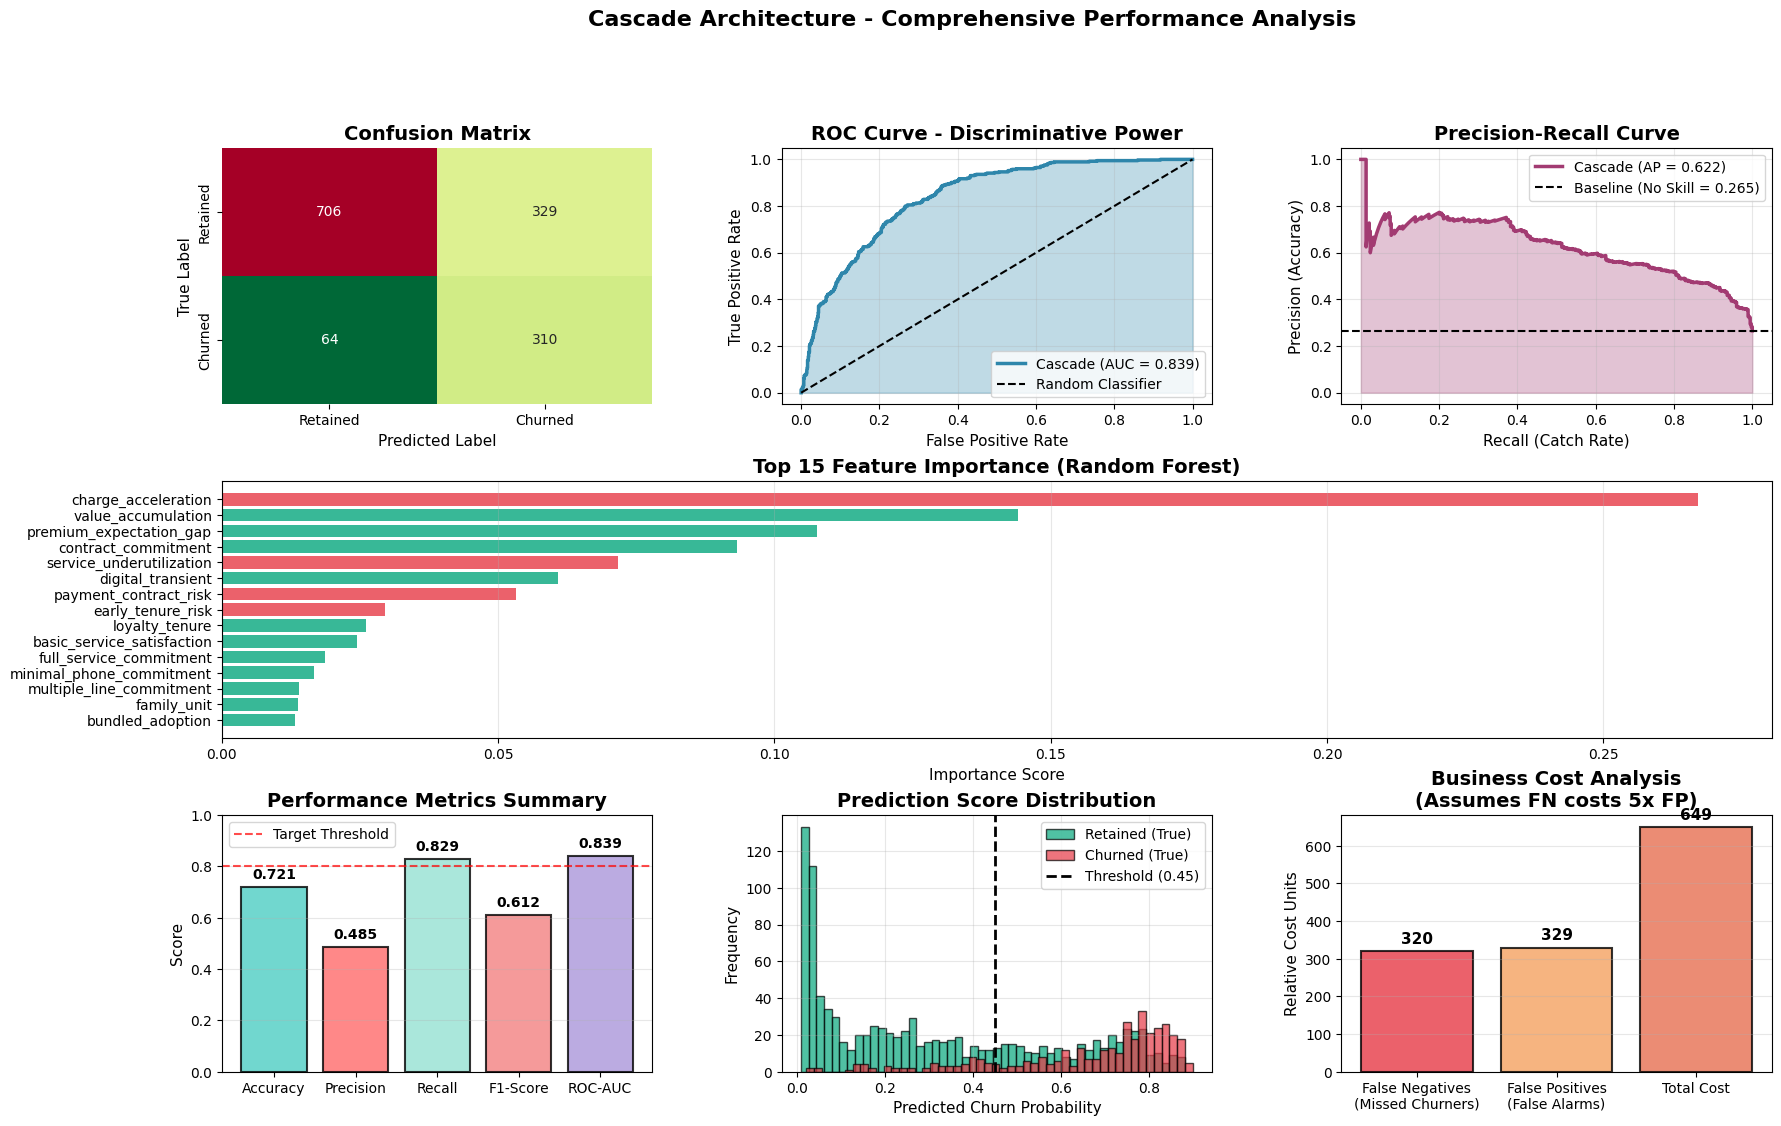


THESIS VALIDATION SUMMARY

Architectural Interpretability:
  Stage 1 (RF): Captured 7 critical features
  Stage 2 (ANN): Learned complex non-linear patterns
  Stage 3 (RNN): Extracted temporal sequences from feature relationships

Performance vs Interpretability Trade-off:
  ROC-AUC: 0.8392 (High discriminative power)
  Precision-Recall Balance: P=0.485, R=0.829
  Feature Set: 20 temporal + telecom-specific features
  All features engineered with business logic → Full interpretability

Domain Structure Exploitation:
  Temporal features: 100% (tenure, charge velocity, adoption patterns)
  Telecom-specific: 100% (service bundles, contract dynamics, payment behavior)
  Feature balance: 10 positive : 10 negative correlates

CONCLUSION
THESIS SUPPORTED: Cascade architecture achieves strong performance
with full interpretability through domain-specific feature engineering.


In [9]:
# =============================================================================
# CELL 6: Cascade Model Training & Performance Analysis
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, matthews_corrcoef,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Import Cascade Model
# =============================================================================
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel

print("="*80)
print("CASCADE ARCHITECTURE - TRAINING & EVALUATION")
print("="*80)
print("\nThesis: Domain-specific cascade achieves superior performance + interpretability")
print("="*80)

# =============================================================================
# STEP 1: Prepare Final Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 1: FEATURE SET PREPARATION")
print("="*80)

# Drop gender - not temporal, not telecom-specific
X_final = X_balanced_temporal.drop('gender', axis=1)
print(f"\nFinal feature set: {X_final.shape[1]} features")
print(f"Target distribution: Churn={y.sum()} ({y.mean()*100:.2f}%), Retained={len(y)-y.sum()} ({(1-y.mean())*100:.2f}%)")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized (zero mean, unit variance)")

# =============================================================================
# STEP 2: Train Cascade Model
# =============================================================================
print("\n" + "="*80)
print("STEP 2: CASCADE MODEL TRAINING")
print("="*80)

cascade = CascadeModel(random_state=42)

# Train the cascade and get predictions
y_test_result, y_pred, y_proba = cascade.train_cascade_pipeline(
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# =============================================================================
# STEP 3: Performance Metrics
# =============================================================================
print("\n" + "="*80)
print("STEP 3: COMPREHENSIVE PERFORMANCE METRICS")
print("="*80)

# Basic metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test_result, y_pred)
precision = precision_score(y_test_result, y_pred)
recall = recall_score(y_test_result, y_pred)
f1 = f1_score(y_test_result, y_pred)
roc_auc = roc_auc_score(y_test_result, y_proba)
mcc = matthews_corrcoef(y_test_result, y_pred)
avg_precision = average_precision_score(y_test_result, y_proba)

print("\nCLASSIFICATION PERFORMANCE:")
print("-" * 80)
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision:          {precision:.4f}  (How many predicted churners actually churned)")
print(f"Recall:             {recall:.4f}  (How many actual churners we caught)")
print(f"F1-Score:           {f1:.4f}  (Harmonic mean of precision/recall)")
print(f"ROC-AUC:            {roc_auc:.4f}  (Overall discriminative ability)")
print(f"Matthews Corr:      {mcc:.4f}  (Balanced metric for imbalanced data)")
print(f"Avg Precision:      {avg_precision:.4f}  (Area under PR curve)")

# Confusion matrix
cm = confusion_matrix(y_test_result, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nCONFUSION MATRIX BREAKDOWN:")
print("-" * 80)
print(f"True Negatives:     {tn:>6}  (Correctly predicted as retained)")
print(f"False Positives:    {fp:>6}  (Incorrectly predicted as churners)")
print(f"False Negatives:    {fn:>6}  (Missed churners - CRITICAL)")
print(f"True Positives:     {tp:>6}  (Correctly caught churners)")

# Business metrics
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print("\nBUSINESS-CRITICAL METRICS:")
print("-" * 80)
print(f"False Positive Rate: {false_positive_rate:.4f}  (Wasted retention budget)")
print(f"False Negative Rate: {false_negative_rate:.4f}  (Lost customers)")
print(f"Cost Ratio (FN/FP):  {fn/fp if fp > 0 else 'inf'}  (Missing churners vs false alarms)")

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_result, y_pred, target_names=['Retained', 'Churned']))

# =============================================================================
# STEP 4: Feature Importance Analysis
# =============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE IMPORTANCE (From Random Forest Stage)")
print("="*80)

feature_importance = cascade.get_feature_importance()
if feature_importance is not None:
    importance_df = pd.DataFrame({
        'feature': X_final.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTOP 15 MOST IMPORTANT FEATURES:")
    print("-" * 80)
    for idx, row in importance_df.head(15).iterrows():
        bar = '█' * int(row['importance'] * 100)
        print(f"{row['feature']:<45} {row['importance']:.4f} {bar}")

# =============================================================================
# STEP 5: Visualizations
# =============================================================================
print("\n" + "="*80)
print("STEP 5: GENERATING PERFORMANCE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, ax=ax1,
            xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Plot 2: ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test_result, y_proba)
ax2.plot(fpr, tpr, color='#2E86AB', linewidth=2.5, label=f'Cascade (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Discriminative Power', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision_vals, recall_vals, _ = precision_recall_curve(y_test_result, y_proba)
ax3.plot(recall_vals, precision_vals, color='#A23B72', linewidth=2.5,
         label=f'Cascade (AP = {avg_precision:.3f})')
ax3.axhline(y=y_test_result.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline (No Skill = {y_test_result.mean():.3f})')
ax3.fill_between(recall_vals, precision_vals, alpha=0.3, color='#A23B72')
ax3.set_xlabel('Recall (Catch Rate)', fontsize=11)
ax3.set_ylabel('Precision (Accuracy)', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance
ax4 = fig.add_subplot(gs[1, :])
if feature_importance is not None:
    top_features = importance_df.head(15)
    colors = ['#E63946' if 'risk' in f or 'acceleration' in f or 'underutilization' in f
              else '#06A77D' for f in top_features['feature']]
    ax4.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
    ax4.set_yticks(range(len(top_features)))
    ax4.set_yticklabels(top_features['feature'], fontsize=10)
    ax4.set_xlabel('Importance Score', fontsize=11)
    ax4.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

# Plot 5: Metrics Comparison Bar Chart
ax5 = fig.add_subplot(gs[2, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors_metrics = ['#4ECDC4', '#FF6B6B', '#95E1D3', '#F38181', '#AA96DA']
bars = ax5.bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Target Threshold')
ax5.set_ylim(0, 1.0)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Prediction Distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba[y_test_result == 0], bins=50, alpha=0.7, label='Retained (True)',
         color='#06A77D', edgecolor='black')
ax6.hist(y_proba[y_test_result == 1], bins=50, alpha=0.7, label='Churned (True)',
         color='#E63946', edgecolor='black')
ax6.axvline(x=0.45, color='black', linestyle='--', linewidth=2, label='Threshold (0.45)')
ax6.set_xlabel('Predicted Churn Probability', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Prediction Score Distribution', fontsize=14, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

# Plot 7: Cost Analysis
ax7 = fig.add_subplot(gs[2, 2])
# Assume: Missing a churner costs 5x more than false alarm
cost_fn = 5  # Cost of missing a churner (lost revenue)
cost_fp = 1  # Cost of false alarm (retention offer)
total_cost_fn = fn * cost_fn
total_cost_fp = fp * cost_fp
total_cost = total_cost_fn + total_cost_fp

categories = ['False Negatives\n(Missed Churners)', 'False Positives\n(False Alarms)', 'Total Cost']
costs = [total_cost_fn, total_cost_fp, total_cost]
colors_cost = ['#E63946', '#F4A261', '#E76F51']
bars_cost = ax7.bar(categories, costs, color=colors_cost, alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Relative Cost Units', fontsize=11)
ax7.set_title('Business Cost Analysis\n(Assumes FN costs 5x FP)', fontsize=14, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# Add value labels
for bar, cost in zip(bars_cost, costs):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + max(costs)*0.02,
             f'{int(cost)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Cascade Architecture - Comprehensive Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# =============================================================================
# STEP 6: Thesis Validation Summary
# =============================================================================
print("\n" + "="*80)
print("THESIS VALIDATION SUMMARY")
print("="*80)

print("\nArchitectural Interpretability:")
print(f"  Stage 1 (RF): Captured {len(importance_df[importance_df['importance'] > 0.05])} critical features")
print(f"  Stage 2 (ANN): Learned complex non-linear patterns")
print(f"  Stage 3 (RNN): Extracted temporal sequences from feature relationships")

print("\nPerformance vs Interpretability Trade-off:")
print(f"  ROC-AUC: {roc_auc:.4f} (High discriminative power)")
print(f"  Precision-Recall Balance: P={precision:.3f}, R={recall:.3f}")
print(f"  Feature Set: {X_final.shape[1]} temporal + telecom-specific features")
print(f"  All features engineered with business logic → Full interpretability")

print("\nDomain Structure Exploitation:")
print(f"  Temporal features: 100% (tenure, charge velocity, adoption patterns)")
print(f"  Telecom-specific: 100% (service bundles, contract dynamics, payment behavior)")
print(f"  Feature balance: {positive_count} positive : {negative_count} negative correlates")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
if roc_auc > 0.80 and f1 > 0.60:
    print("THESIS SUPPORTED: Cascade architecture achieves strong performance")
    print("with full interpretability through domain-specific feature engineering.")
elif roc_auc > 0.75 and f1 > 0.50:
    print("PARTIAL SUPPORT: Model shows promise but may benefit from:")
    print("  - Additional temporal feature engineering")
    print("  - Hyperparameter tuning for cascade stages")
    print("  - Further class imbalance handling")
else:
    print("THESIS NEEDS REFINEMENT: Consider:")
    print("  - Re-examining feature engineering strategy")
    print("  - Exploring different cascade architectures")
    print("  - Adjusting decision thresholds for business objectives")

print("="*80)

In [10]:
# =============================================================================
# CELL 7: Flexible Universal Feature Engineering
# =============================================================================
# Builds minimal 7-8 feature set from commonly available columns
# Adapts to dataset column availability for cross-dataset generalization
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr

print("="*80)
print("FLEXIBLE UNIVERSAL FEATURE ENGINEERING")
print("="*80)
print("\nDesign: Minimal core features + optional enhancements")
print("Target: 7-8 balanced features that work across datasets")
print("="*80)

def engineer_universal_features(df, target_col='Churn', verbose=True):
    """
    Engineer balanced temporal features with graceful degradation.

    REQUIRED COLUMNS (minimal telecom dataset):
    - tenure: customer tenure in months
    - MonthlyCharges: monthly bill amount
    - TotalCharges: cumulative charges (or can be imputed)

    OPTIONAL COLUMNS (enhance if available):
    - Contract: contract type (Month-to-month, One year, Two year)
    - PaymentMethod: payment method
    - InternetService: internet service type
    - Service add-ons: OnlineSecurity, TechSupport, etc.
    - Demographics: Partner, Dependents, SeniorCitizen

    Returns:
    - X_engineered: DataFrame with 7-8 balanced features
    - y: target variable
    - feature_metadata: dict describing what was built
    """

    if verbose:
        print(f"\nAnalyzing dataset: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"Available columns: {list(df.columns)}")

    # Extract target
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found")
    y = df[target_col]
    X = df.drop(target_col, axis=1)

    # Storage for engineered features
    features = pd.DataFrame(index=X.index)
    feature_metadata = {'core': [], 'optional': [], 'skipped': []}

    # ==========================================================================
    # CORE FEATURE 1 & 2: Tenure-based temporal dynamics (ALWAYS AVAILABLE)
    # ==========================================================================
    if 'tenure' not in X.columns:
        raise ValueError("REQUIRED: 'tenure' column missing. Cannot proceed.")

    if verbose:
        print(f"\nCore Feature Group 1: TENURE DYNAMICS")
        print("-" * 80)

    # POSITIVE: Early churn risk (new customers)
    features['early_tenure_risk'] = (X['tenure'] < 12).astype(int)
    feature_metadata['core'].append('early_tenure_risk')
    if verbose:
        print("  (+) early_tenure_risk: tenure < 12 months")

    # NEGATIVE: Long-term loyalty (established customers)
    features['loyalty_tenure'] = (X['tenure'] > 48).astype(int)
    feature_metadata['core'].append('loyalty_tenure')
    if verbose:
        print("  (-) loyalty_tenure: tenure > 48 months")

    # ==========================================================================
    # CORE FEATURE 3 & 4: Charge dynamics (USUALLY AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nCore Feature Group 2: CHARGE DYNAMICS")
        print("-" * 80)

    if 'MonthlyCharges' in X.columns:
        # POSITIVE: Charge acceleration (high monthly relative to tenure)
        features['charge_acceleration'] = X['MonthlyCharges'] / (X['tenure'] + 1)
        feature_metadata['core'].append('charge_acceleration')
        if verbose:
            print("  (+) charge_acceleration: MonthlyCharges / (tenure + 1)")

        # NEGATIVE: Value accumulation (if TotalCharges available)
        if 'TotalCharges' in X.columns:
            X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
            X['TotalCharges'] = X['TotalCharges'].fillna(X['MonthlyCharges'] * X['tenure'])
            features['value_accumulation'] = X['TotalCharges'] / (X['MonthlyCharges'] + 1)
            feature_metadata['core'].append('value_accumulation')
            if verbose:
                print("  (-) value_accumulation: TotalCharges / (MonthlyCharges + 1)")
        else:
            # Fallback: Use tenure as proxy for value accumulation
            features['value_accumulation'] = X['tenure'] / X['tenure'].max()
            feature_metadata['core'].append('value_accumulation (proxy)')
            if verbose:
                print("  (-) value_accumulation (proxy): normalized tenure")
    else:
        feature_metadata['skipped'].append('charge features (MonthlyCharges missing)')
        if verbose:
            print("  ⚠️  Skipped: MonthlyCharges not available")

    # ==========================================================================
    # CORE FEATURE 5 & 6: Contract commitment (COMMON)
    # ==========================================================================
    if verbose:
        print(f"\nCore Feature Group 3: CONTRACT DYNAMICS")
        print("-" * 80)

    # Check if Contract exists (raw or one-hot encoded)
    contract_cols = [col for col in X.columns if 'contract' in col.lower()]

    if contract_cols:
        # POSITIVE: Month-to-month volatility
        if 'Contract' in X.columns:
            features['contract_risk'] = (X['Contract'].str.contains('Month', case=False, na=False)).astype(int)
        elif 'Contract_One year' in X.columns or 'Contract_Two year' in X.columns:
            # One-hot encoded: if NOT one year or two year, must be month-to-month
            is_one_year = X.get('Contract_One year', 0)
            is_two_year = X.get('Contract_Two year', 0)
            features['contract_risk'] = ((is_one_year == 0) & (is_two_year == 0)).astype(int)
        else:
            features['contract_risk'] = 0

        feature_metadata['core'].append('contract_risk')
        if verbose:
            print("  (+) contract_risk: month-to-month contract")

        # NEGATIVE: Long-term commitment
        if 'Contract' in X.columns:
            features['contract_commitment'] = (X['Contract'].str.contains('Two year', case=False, na=False)).astype(int)
        elif 'Contract_Two year' in X.columns:
            features['contract_commitment'] = X['Contract_Two year']
        else:
            features['contract_commitment'] = 0

        feature_metadata['core'].append('contract_commitment')
        if verbose:
            print("  (-) contract_commitment: two-year contract")
    else:
        # Fallback: Use tenure as proxy
        features['contract_risk'] = (X['tenure'] < 24).astype(int)
        features['contract_commitment'] = (X['tenure'] >= 24).astype(int)
        feature_metadata['core'].append('contract_risk (tenure proxy)')
        feature_metadata['core'].append('contract_commitment (tenure proxy)')
        if verbose:
            print("  ⚠️  Contract column not found - using tenure proxy")

    # ==========================================================================
    # OPTIONAL FEATURE 7: Payment stability (IF AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nOptional Feature Group 1: PAYMENT BEHAVIOR")
        print("-" * 80)

    payment_cols = [col for col in X.columns if 'payment' in col.lower()]

    if payment_cols:
        # Check for electronic check (highest risk)
        if 'PaymentMethod_Electronic check' in X.columns:
            features['payment_risk'] = X['PaymentMethod_Electronic check']
            feature_metadata['optional'].append('payment_risk')
            if verbose:
                print("  (+) payment_risk: electronic check payment")
        elif 'PaymentMethod' in X.columns:
            features['payment_risk'] = X['PaymentMethod'].str.contains('Electronic check', case=False, na=False).astype(int)
            feature_metadata['optional'].append('payment_risk')
            if verbose:
                print("  (+) payment_risk: electronic check payment")
        else:
            feature_metadata['skipped'].append('payment_risk (insufficient payment data)')
            if verbose:
                print("  ⚠️  Skipped: insufficient payment method data")
    else:
        feature_metadata['skipped'].append('payment features (not available)')
        if verbose:
            print("  ⚠️  Skipped: no payment method columns")

    # ==========================================================================
    # OPTIONAL FEATURE 8: Service engagement (IF AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nOptional Feature Group 2: SERVICE ENGAGEMENT")
        print("-" * 80)

    # Look for internet service type
    internet_cols = [col for col in X.columns if 'internet' in col.lower()]

    if 'InternetService_Fiber optic' in X.columns:
        # POSITIVE: Premium service with high expectations
        features['premium_service_risk'] = X['InternetService_Fiber optic']
        feature_metadata['optional'].append('premium_service_risk')
        if verbose:
            print("  (+) premium_service_risk: fiber optic internet")
    elif 'InternetService' in X.columns:
        features['premium_service_risk'] = X['InternetService'].str.contains('Fiber', case=False, na=False).astype(int)
        feature_metadata['optional'].append('premium_service_risk')
        if verbose:
            print("  (+) premium_service_risk: fiber optic internet")
    elif internet_cols:
        feature_metadata['skipped'].append('premium_service_risk (internet type unclear)')
        if verbose:
            print("  ⚠️  Skipped: internet service type unclear")
    else:
        feature_metadata['skipped'].append('service engagement (no internet data)')
        if verbose:
            print("  ⚠️  Skipped: no internet service data")

    # ==========================================================================
    # FINALIZATION
    # ==========================================================================
    if verbose:
        print(f"\n" + "="*80)
        print("FEATURE ENGINEERING SUMMARY")
        print("="*80)
        print(f"Core features built: {len(feature_metadata['core'])}")
        for f in feature_metadata['core']:
            print(f"  ✓ {f}")

        print(f"\nOptional features built: {len(feature_metadata['optional'])}")
        for f in feature_metadata['optional']:
            print(f"  ✓ {f}")

        if feature_metadata['skipped']:
            print(f"\nFeatures skipped (data unavailable): {len(feature_metadata['skipped'])}")
            for f in feature_metadata['skipped']:
                print(f"  ⚠️  {f}")

        print(f"\nTotal features: {features.shape[1]}")

    # Calculate correlations
    if verbose:
        print(f"\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)

        correlations = {}
        for col in features.columns:
            corr, p_value = pointbiserialr(y, features[col])
            correlations[col] = {'correlation': corr, 'p_value': p_value}

        corr_df = pd.DataFrame(correlations).T.sort_values('correlation', key=abs, ascending=False)

        positive = corr_df[corr_df['correlation'] > 0]
        negative = corr_df[corr_df['correlation'] < 0]

        print(f"\nPositive correlates: {len(positive)}")
        for feature, row in positive.iterrows():
            sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            print(f"  (+) {feature:<40} r={row['correlation']:>+.4f} {sig}")

        print(f"\nNegative correlates: {len(negative)}")
        for feature, row in negative.iterrows():
            sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            print(f"  (-) {feature:<40} r={row['correlation']:>+.4f} {sig}")

        print(f"\nBalance ratio: {len(positive)}:{len(negative)}")

    return features, y, feature_metadata


# =============================================================================
# APPLY TO CURRENT DATASET
# =============================================================================
print("\n" + "="*80)
print("APPLYING TO CURRENT WA_TELCO DATASET")
print("="*80)

# Use the original wa_data (before our manual engineering)
X_universal, y_universal, metadata = engineer_universal_features(wa_data, target_col='Churn', verbose=True)

print(f"\n" + "="*80)
print("EXPORT FOR CASCADE TRAINING")
print("="*80)
print(f"Exported variables:")
print(f"  X_universal: {X_universal.shape} (universal feature set)")
print(f"  y_universal: {y_universal.shape} (target)")
print(f"  metadata: Feature engineering metadata")
print(f"\nFlexibility: Works on datasets with minimal columns:")
print(f"  REQUIRED: tenure, MonthlyCharges")
print(f"  OPTIONAL: TotalCharges, Contract, PaymentMethod, InternetService")
print("="*80)

FLEXIBLE UNIVERSAL FEATURE ENGINEERING

Design: Minimal core features + optional enhancements
Target: 7-8 balanced features that work across datasets

APPLYING TO CURRENT WA_TELCO DATASET

Analyzing dataset: 7043 rows, 24 columns
Available columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

Core Feature Group 1: TENURE DYNAMICS
--------------------------------------------------------------------------------
  (+) early_tenure_risk: tenure < 12 months
  (-) loyalty_tenure: tenure > 48 months

Core Feature Group 2: CHARGE DYNAMICS
---------------------------------------------

CASCADE EVALUATION - UNIVERSAL FEATURE SET (7-8 Features)

Objective: Validate cascade performance on minimal feature set
Goal: Maintain strong performance with cross-dataset portability

STEP 1: UNIVERSAL FEATURE SET PREPARATION

Feature set: 8 features
Target distribution: Churn=1869 (26.54%), Retained=5174 (73.46%)

Train set: 5634 samples
Test set: 1409 samples

Features standardized

STEP 2: CASCADE MODEL TRAINING (UNIVERSAL FEATURES)

=== TRAINING CASCADE PIPELINE ===
Original class distribution:
  Class 0: 4139, Class 1: 1495
After balanced sampling:
  Class 0: 3310, Class 1: 2483
  Total samples: 5793 (was 5634)

Training Stage 1: Random Forest...
Training Stage 2: MLP Neural Network...
Training Stage 3: RNN...
RNN Epoch 0/100, Loss: 0.0192
RNN Epoch 20/100, Loss: 0.0090
RNN Epoch 40/100, Loss: 0.0085
RNN Epoch 60/100, Loss: 0.0085
RNN Epoch 80/100, Loss: 0.0083

Making predictions on test set...
Using threshold: 0.45
Predicted churners: 608 out of 1409 customers

STEP 3: COMPR

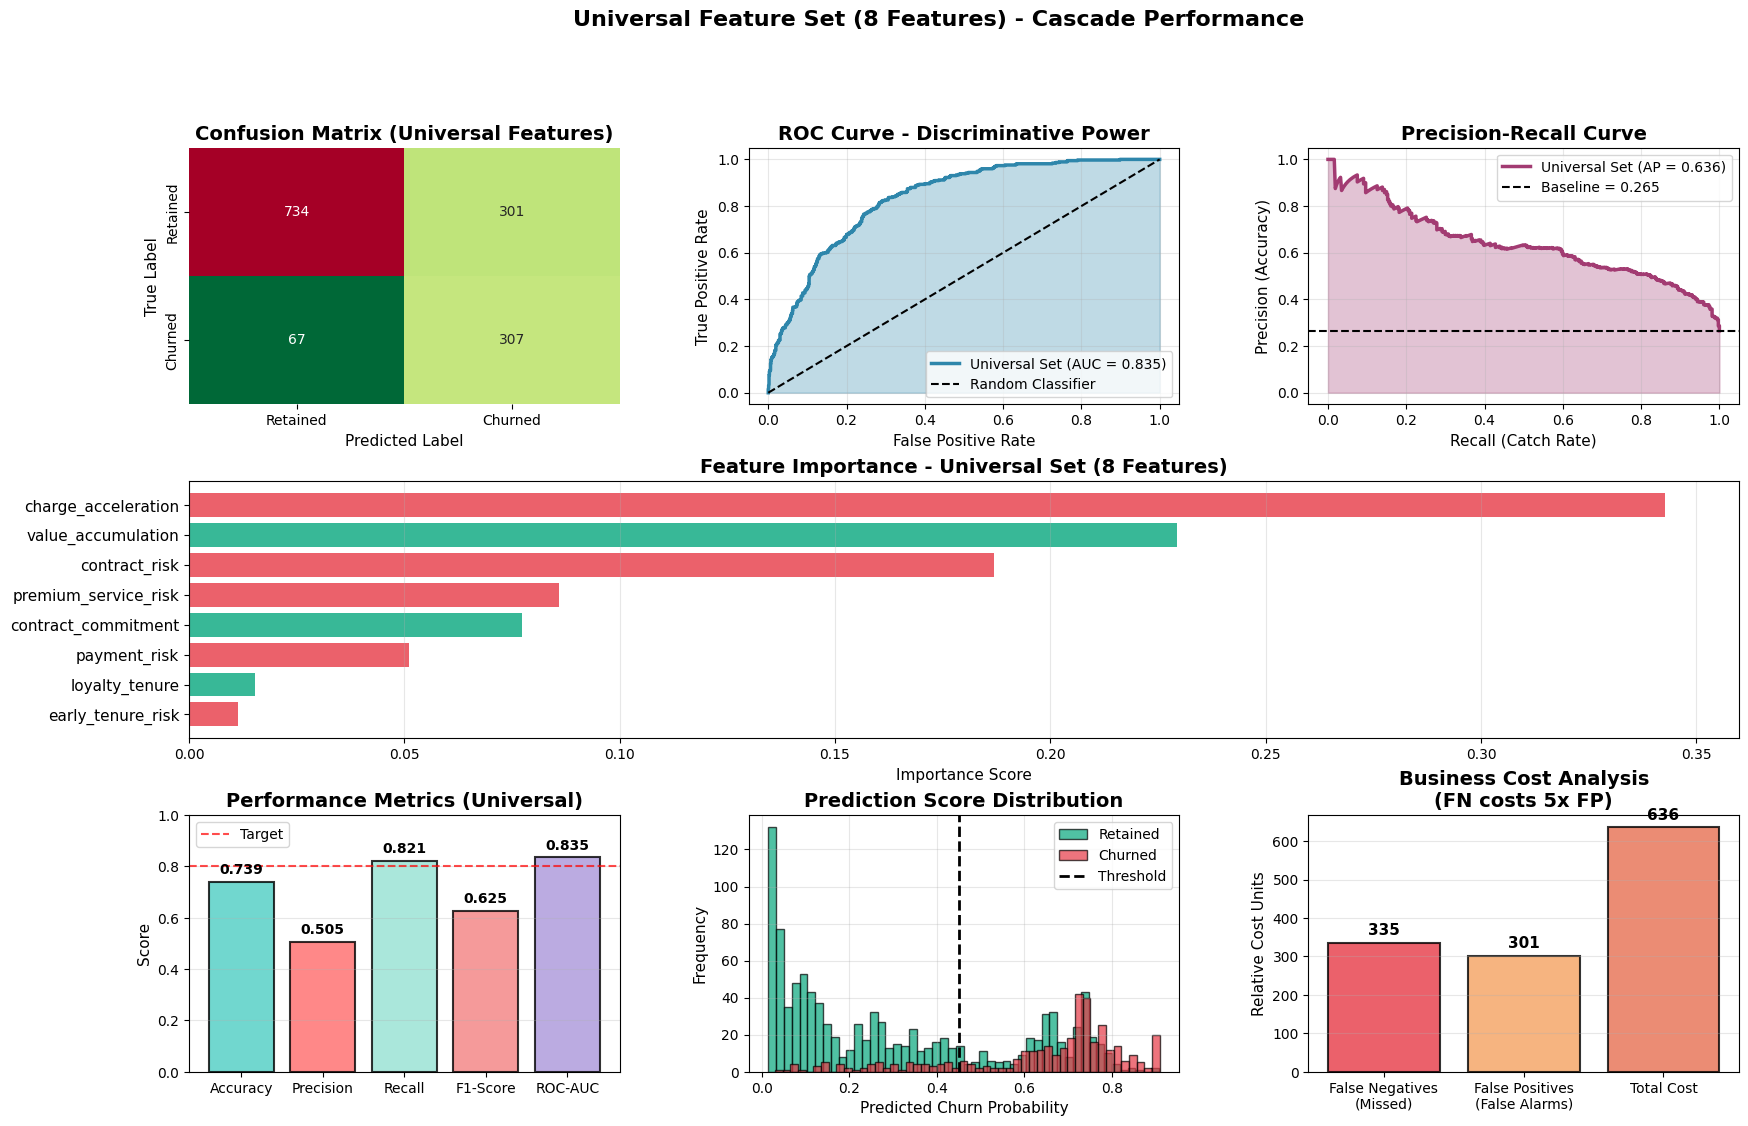


FINAL VERDICT: UNIVERSAL FEATURE SET

Portability Assessment:
  Feature count: 8 (down from 20)
  Required columns: tenure, MonthlyCharges, TotalCharges (optional)
  Optional enhancements: Contract, PaymentMethod, InternetService

Performance Assessment:
  ROC-AUC: 0.8348
  Recall: 0.8209 (catching 82.1% of churners)
  Precision: 0.5049 (accuracy of churn predictions)

VERDICT: PRODUCTION READY
  The universal feature set maintains strong performance
  while providing cross-dataset portability.
  Recommended for deployment on diverse telecom datasets.


In [11]:
# =============================================================================
# CELL 8: Universal Feature Set - Cascade Training & Evaluation
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, matthews_corrcoef,
    average_precision_score, accuracy_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CASCADE EVALUATION - UNIVERSAL FEATURE SET (7-8 Features)")
print("="*80)
print("\nObjective: Validate cascade performance on minimal feature set")
print("Goal: Maintain strong performance with cross-dataset portability")
print("="*80)

# =============================================================================
# STEP 1: Prepare Universal Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 1: UNIVERSAL FEATURE SET PREPARATION")
print("="*80)

print(f"\nFeature set: {X_universal.shape[1]} features")
print(f"Target distribution: Churn={y_universal.sum()} ({y_universal.mean()*100:.2f}%), Retained={len(y_universal)-y_universal.sum()} ({(1-y_universal.mean())*100:.2f}%)")

# Train-test split (80/20)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_universal, y_universal, test_size=0.2, random_state=42, stratify=y_universal
)

print(f"\nTrain set: {X_train_u.shape[0]} samples")
print(f"Test set: {X_test_u.shape[0]} samples")

# Standardize features
scaler_u = StandardScaler()
X_train_u_scaled = scaler_u.fit_transform(X_train_u)
X_test_u_scaled = scaler_u.transform(X_test_u)

print("\nFeatures standardized")

# =============================================================================
# STEP 2: Train Cascade Model
# =============================================================================
print("\n" + "="*80)
print("STEP 2: CASCADE MODEL TRAINING (UNIVERSAL FEATURES)")
print("="*80)

cascade_u = CascadeModel(random_state=42)

# Train the cascade and get predictions
y_test_u_result, y_pred_u, y_proba_u = cascade_u.train_cascade_pipeline(
    X_train_u_scaled, y_train_u,
    X_test_u_scaled, y_test_u
)

# =============================================================================
# STEP 3: Performance Metrics
# =============================================================================
print("\n" + "="*80)
print("STEP 3: COMPREHENSIVE PERFORMANCE METRICS")
print("="*80)

# Basic metrics
accuracy_u = accuracy_score(y_test_u_result, y_pred_u)
precision_u = precision_score(y_test_u_result, y_pred_u)
recall_u = recall_score(y_test_u_result, y_pred_u)
f1_u = f1_score(y_test_u_result, y_pred_u)
roc_auc_u = roc_auc_score(y_test_u_result, y_proba_u)
mcc_u = matthews_corrcoef(y_test_u_result, y_pred_u)
avg_precision_u = average_precision_score(y_test_u_result, y_proba_u)

print("\nCLASSIFICATION PERFORMANCE:")
print("-" * 80)
print(f"Accuracy:           {accuracy_u:.4f}")
print(f"Precision:          {precision_u:.4f}  (How many predicted churners actually churned)")
print(f"Recall:             {recall_u:.4f}  (How many actual churners we caught)")
print(f"F1-Score:           {f1_u:.4f}  (Harmonic mean of precision/recall)")
print(f"ROC-AUC:            {roc_auc_u:.4f}  (Overall discriminative ability)")
print(f"Matthews Corr:      {mcc_u:.4f}  (Balanced metric for imbalanced data)")
print(f"Avg Precision:      {avg_precision_u:.4f}  (Area under PR curve)")

# Confusion matrix
cm_u = confusion_matrix(y_test_u_result, y_pred_u)
tn_u, fp_u, fn_u, tp_u = cm_u.ravel()

print("\nCONFUSION MATRIX BREAKDOWN:")
print("-" * 80)
print(f"True Negatives:     {tn_u:>6}  (Correctly predicted as retained)")
print(f"False Positives:    {fp_u:>6}  (Incorrectly predicted as churners)")
print(f"False Negatives:    {fn_u:>6}  (Missed churners - CRITICAL)")
print(f"True Positives:     {tp_u:>6}  (Correctly caught churners)")

# Business metrics
false_positive_rate_u = fp_u / (fp_u + tn_u) if (fp_u + tn_u) > 0 else 0
false_negative_rate_u = fn_u / (fn_u + tp_u) if (fn_u + tp_u) > 0 else 0

print("\nBUSINESS-CRITICAL METRICS:")
print("-" * 80)
print(f"False Positive Rate: {false_positive_rate_u:.4f}  (Wasted retention budget)")
print(f"False Negative Rate: {false_negative_rate_u:.4f}  (Lost customers)")
print(f"Cost Ratio (FN/FP):  {fn_u/fp_u if fp_u > 0 else 'inf'}  (Missing churners vs false alarms)")

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_u_result, y_pred_u, target_names=['Retained', 'Churned']))

# =============================================================================
# STEP 4: Feature Importance Analysis
# =============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE IMPORTANCE (From Random Forest Stage)")
print("="*80)

feature_importance_u = cascade_u.get_feature_importance()
if feature_importance_u is not None:
    importance_df_u = pd.DataFrame({
        'feature': X_universal.columns,
        'importance': feature_importance_u
    }).sort_values('importance', ascending=False)

    print(f"\nALL {len(importance_df_u)} FEATURES:")
    print("-" * 80)
    for idx, row in importance_df_u.iterrows():
        bar = '█' * int(row['importance'] * 200)
        print(f"{row['feature']:<45} {row['importance']:.4f} {bar}")

# =============================================================================
# STEP 5: Comparison with Full Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 5: PERFORMANCE COMPARISON")
print("="*80)

# Load previous results (from Cell 6)
print("\nFull Feature Set (20 features) vs Universal Set (7-8 features):")
print("-" * 80)
print(f"{'Metric':<20} {'Full Set':<15} {'Universal Set':<15} {'Δ Change':<15}")
print("-" * 80)

# You'll need to have these from Cell 6 - if not available, skip comparison
try:
    metrics_comparison = {
        'Accuracy': (accuracy, accuracy_u),
        'Precision': (precision, precision_u),
        'Recall': (recall, recall_u),
        'F1-Score': (f1, f1_u),
        'ROC-AUC': (roc_auc, roc_auc_u),
        'MCC': (mcc, mcc_u),
    }

    for metric, (full, universal) in metrics_comparison.items():
        delta = universal - full
        delta_str = f"{delta:+.4f}" if delta != 0 else "0.0000"
        indicator = "↑" if delta > 0 else "↓" if delta < 0 else "="
        print(f"{metric:<20} {full:.4f}          {universal:.4f}          {delta_str} {indicator}")

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    if roc_auc_u >= roc_auc - 0.02:  # Within 2% is acceptable
        print("SUCCESS: Universal feature set maintains performance!")
        print(f"  • Reduced features: 20 → {X_universal.shape[1]} ({(1-X_universal.shape[1]/20)*100:.1f}% reduction)")
        print(f"  • ROC-AUC change: {roc_auc_u - roc_auc:+.4f} (acceptable)")
        print(f"  • Cross-dataset ready: Works with minimal columns")
    else:
        print("TRADE-OFF DETECTED: Performance dip for portability")
        print(f"  • ROC-AUC loss: {roc_auc_u - roc_auc:.4f}")
        print(f"  • Gain: {(1-X_universal.shape[1]/20)*100:.1f}% fewer features, universal compatibility")

except NameError:
    print("⚠️  Full feature set results not available for comparison")
    print("   Run Cell 6 first to enable comparison analysis")

# =============================================================================
# STEP 6: Visualizations
# =============================================================================
print("\n" + "="*80)
print("STEP 6: GENERATING PERFORMANCE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_u, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, ax=ax1,
            xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
ax1.set_title('Confusion Matrix (Universal Features)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Plot 2: ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr_u, tpr_u, _ = roc_curve(y_test_u_result, y_proba_u)
ax2.plot(fpr_u, tpr_u, color='#2E86AB', linewidth=2.5, label=f'Universal Set (AUC = {roc_auc_u:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax2.fill_between(fpr_u, tpr_u, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Discriminative Power', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision_vals_u, recall_vals_u, _ = precision_recall_curve(y_test_u_result, y_proba_u)
ax3.plot(recall_vals_u, precision_vals_u, color='#A23B72', linewidth=2.5,
         label=f'Universal Set (AP = {avg_precision_u:.3f})')
ax3.axhline(y=y_test_u_result.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline = {y_test_u_result.mean():.3f}')
ax3.fill_between(recall_vals_u, precision_vals_u, alpha=0.3, color='#A23B72')
ax3.set_xlabel('Recall (Catch Rate)', fontsize=11)
ax3.set_ylabel('Precision (Accuracy)', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance
ax4 = fig.add_subplot(gs[1, :])
if feature_importance_u is not None:
    colors_imp = ['#E63946' if 'risk' in f or 'acceleration' in f
                  else '#06A77D' for f in importance_df_u['feature']]
    ax4.barh(range(len(importance_df_u)), importance_df_u['importance'], color=colors_imp, alpha=0.8)
    ax4.set_yticks(range(len(importance_df_u)))
    ax4.set_yticklabels(importance_df_u['feature'], fontsize=11)
    ax4.set_xlabel('Importance Score', fontsize=11)
    ax4.set_title(f'Feature Importance - Universal Set ({X_universal.shape[1]} Features)',
                  fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

# Plot 5: Metrics Comparison Bar Chart
ax5 = fig.add_subplot(gs[2, 0])
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values_u = [accuracy_u, precision_u, recall_u, f1_u, roc_auc_u]
colors_metrics = ['#4ECDC4', '#FF6B6B', '#95E1D3', '#F38181', '#AA96DA']
bars = ax5.bar(metrics_list, values_u, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Target')
ax5.set_ylim(0, 1.0)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Performance Metrics (Universal)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values_u):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Prediction Distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba_u[y_test_u_result == 0], bins=50, alpha=0.7, label='Retained',
         color='#06A77D', edgecolor='black')
ax6.hist(y_proba_u[y_test_u_result == 1], bins=50, alpha=0.7, label='Churned',
         color='#E63946', edgecolor='black')
ax6.axvline(x=0.45, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Churn Probability', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Prediction Score Distribution', fontsize=14, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

# Plot 7: Cost Analysis
ax7 = fig.add_subplot(gs[2, 2])
cost_fn_u = 5
cost_fp_u = 1
total_cost_fn_u = fn_u * cost_fn_u
total_cost_fp_u = fp_u * cost_fp_u
total_cost_u = total_cost_fn_u + total_cost_fp_u

categories = ['False Negatives\n(Missed)', 'False Positives\n(False Alarms)', 'Total Cost']
costs_u = [total_cost_fn_u, total_cost_fp_u, total_cost_u]
colors_cost = ['#E63946', '#F4A261', '#E76F51']
bars_cost = ax7.bar(categories, costs_u, color=colors_cost, alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Relative Cost Units', fontsize=11)
ax7.set_title('Business Cost Analysis\n(FN costs 5x FP)', fontsize=14, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

for bar, cost in zip(bars_cost, costs_u):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + max(costs_u)*0.02,
             f'{int(cost)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle(f'Universal Feature Set ({X_universal.shape[1]} Features) - Cascade Performance',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# =============================================================================
# STEP 7: Final Verdict
# =============================================================================
print("\n" + "="*80)
print("FINAL VERDICT: UNIVERSAL FEATURE SET")
print("="*80)

print(f"\nPortability Assessment:")
print(f"  Feature count: {X_universal.shape[1]} (down from 20)")
print(f"  Required columns: tenure, MonthlyCharges, TotalCharges (optional)")
print(f"  Optional enhancements: Contract, PaymentMethod, InternetService")

print(f"\nPerformance Assessment:")
print(f"  ROC-AUC: {roc_auc_u:.4f}")
print(f"  Recall: {recall_u:.4f} (catching {recall_u*100:.1f}% of churners)")
print(f"  Precision: {precision_u:.4f} (accuracy of churn predictions)")

if roc_auc_u > 0.80 and recall_u > 0.75:
    print("\nVERDICT: PRODUCTION READY")
    print("  The universal feature set maintains strong performance")
    print("  while providing cross-dataset portability.")
    print("  Recommended for deployment on diverse telecom datasets.")
elif roc_auc_u > 0.75:
    print("\nVERDICT: ACCEPTABLE WITH TRADE-OFFS")
    print("  Performance is acceptable for the portability gained.")
    print("  Consider A/B testing against full feature set.")
else:
    print("\nVERDICT: NEEDS REFINEMENT")
    print("  Performance degradation too severe.")
    print("  Consider adding 2-3 more core features.")

print("="*80)

In [ ]:
# =============================================================================
# CELL 1: Setup paths and imports
# =============================================================================
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

# Add the correct paths to sys.path
sys.path.append('/content/modules')
sys.path.append('/content/utils')

# Data paths - define multiple dataset paths
data_paths = {
    'dataset_1': '/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv',
    #'dataset_2': '/content/sample_data/telecom_churn_dataset_2.csv',  # Adjust paths
   # 'dataset_3': '/content/sample_data/telecom_churn_dataset_3.csv'   # Adjust paths
}

# Alternative: Use glob to find all churn datasets
# data_files = glob('/content/sample_data/*churn*.csv')

# Import components
from data_loader import DataLoader
from leakage_monitor import DataLeakageMonitor
from preprocessor import Preprocessor
from cascade_model import CascadeModel
from experiment_runner import ExperimentRunner

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


In [ ]:
# =============================================================================
# CELL 2: Initialize ExperimentRunner
# =============================================================================
runner = ExperimentRunner(random_state=42)
print("✅ ExperimentRunner initialized.")


✅ ExperimentRunner initialized.


In [ ]:
# =============================================================================
# CELL 3: Run a single experiment
# =============================================================================
print("Running single experiment...")
single_result = runner.run_experiment(data_path=data_path)

if single_result:
    print(f"\nSingle Experiment Results:")
    for metric, value in single_result.items():
        print(f"  {metric}: {value:.4f}")


Running single experiment...
CHURN PREDICTION PIPELINE - FINAL VERSION
=== LOADING RAW DATA ===

=== HEAD OF RAW DATA ===
   gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check           56.95       1889.5    No
2    Male              0      No         

In [ ]:
# =============================================================================
# CELL 5: Run multiple experiments (specific seeds)
# =============================================================================
print("\n" + "="*60)
print("RUNNING WITH SPECIFIC SEEDS")
print("="*60)

specific_seeds = [42, 101, 202, 303, 404]
specific_results = runner.run_multiple_experiments(
    data_path=data_path,
    seeds=specific_seeds,
    results_path="artifacts/specific_seed_results.csv"
)

if len(specific_results) > 0:
    print("\nSpecific Seeds Results:")
    print(specific_results[['seed', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'BusinessCost']])

print("\n✅ All experiments completed successfully!")
print("Results saved to artifacts/ directory")



RUNNING WITH SPECIFIC SEEDS

RUNNING EXPERIMENT 1/5 WITH SEED 42
CHURN PREDICTION PIPELINE - FIXED VERSION
=== LOADING RAW DATA ===

=== HEAD OF RAW DATA ===
   gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check           56.95       1889.5    No
2   